In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tq
import pandas as pd
import numpy as np
import pickle
import nltk
from gensim import corpora, matutils, models, similarities
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
import os
from nameparser.parser import HumanName
from nltk.stem import WordNetLemmatizer 
import pyLDAvis.gensim
from utils.clean_text import *
from utils.stop_word_list import *
import gensim

/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping, Sequence  # noqa


In [ ]:
pos_df = pd.read_csv('../data/positive_comments.csv')
neg_df = pd.read_csv('../data/negative_comments.csv')

In [ ]:
pos_comments = pd.DataFrame(pos_df.body)
neg_comments = pd.DataFrame(neg_df.body)

In [ ]:
%%time
pos_comments = clean_all(pos_comments, 'body')

In [ ]:
pos_comments.to_csv('../data/positive_comments_processed.csv',index=False)

In [ ]:
%%time
neg_comments = clean_all(neg_comments, 'body')

neg_comments.to_csv('../data/negative_comments_processed.csv',index=False)

In [2]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [3]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [4]:
# Concatenate n-grams
def replace_ngram(x,bigrams,trigrams):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [5]:
# Filter for only nouns
def noun_only(x):
    comment = nltk.pos_tag(x)
    filtered = [word[0] for word in comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [6]:
def preprocess(comments):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in comments.body])
    # Filter only those that occur at least 50 times
    finder.apply_freq_filter(50)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)

    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    print("bigram process done")

    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in comments.body])
    # Filter only those that occur at least 50 times
    finder.apply_freq_filter(50)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    print("trigram process done")
    
    # Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
    # choose top 500 ngrams in this case ranked by PMI that have noun like structures
    filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                                  bigram_filter(bigram['bigram'])\
                                                  and bigram.pmi > 5, axis = 1)][:500]

    filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                     trigram_filter(trigram['trigram'])\
                                                     and trigram.pmi > 5, axis = 1)][:500]


    bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
    trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]
    

    comments_w_ngrams = comments.copy()
    comments_w_ngrams.body = comments_w_ngrams.body.map(lambda x: replace_ngram(x,bigrams,trigrams))
    print("replace done")
    
    # tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
    comments_w_ngrams = comments_w_ngrams.body.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and word not in english_names\
                                                              and word not in player_nicknames\
                                                              and word not in team_names\
                                                              and word not in time_words\
                                                              and word not in other_stop_word\
                                                              and len(word) > 2])
    print("remove stopwords done")
    final_comments = comments_w_ngrams.map(noun_only)
    return final_comments

In [7]:
%%time
pos_comments = pd.read_csv('../data/positive_comments_processed.csv')
pos_comments_processed = preprocess(pos_comments)
pickle.dump(pos_comments_processed, open('../data/topic_modeling/pretrained/pos_comments_processed.pkl','wb'))

bigram process done
trigram process done
replace done
remove stopwords done
CPU times: user 13min 36s, sys: 9.19 s, total: 13min 45s
Wall time: 13min 51s


In [8]:
%%time
neg_comments = pd.read_csv('../data/negative_comments_processed.csv')
neg_comments_processed = preprocess(neg_comments)
pickle.dump(neg_comments_processed, open('../data/topic_modeling/pretrained/neg_comments_processed.pkl','wb'))

bigram process done
trigram process done
replace done
remove stopwords done
CPU times: user 11min 45s, sys: 16.5 s, total: 12min 1s
Wall time: 12min 43s


In [ ]:
%%time
dictionary_pos = corpora.Dictionary(pos_comments_processed)
doc_term_matrix_pos = [dictionary_pos.doc2bow(doc) for doc in pos_comments_processed]

In [10]:
dictionary_neg = corpora.Dictionary(neg_comments_processed)
doc_term_matrix_neg = [dictionary_neg.doc2bow(doc) for doc in neg_comments_processed]

In [ ]:
pickle.dump(dictionary_pos, open('../data/topic_modeling/pretrained/pos_dictionary.pkl','wb'))
pickle.dump(doc_term_matrix_pos, open('../data/topic_modeling/pretrained/pos_doc_term_matrix.pkl','wb'))

In [11]:
pickle.dump(dictionary_neg, open('../data/topic_modeling/pretrained/neg_dictionary.pkl','wb'))
pickle.dump(doc_term_matrix_neg, open('../data/topic_modeling/pretrained/neg_doc_term_matrix.pkl','wb'))

### coherence

In [12]:
dictionary_pos = pickle.load(open('../data/topic_modeling/pretrained/pos_dictionary.pkl','rb'))
doc_term_matrix_pos = pickle.load(open('../data/topic_modeling/pretrained/pos_doc_term_matrix.pkl','rb'))

In [13]:
coherence = []

%%time
for k in tq.tqdm(range(5,25)):
    print('Round: '+str(k))
    Lda = models.LdaMulticore
    ldamodel_pos = Lda(doc_term_matrix_pos, num_topics=k, id2word = dictionary_pos, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = models.coherencemodel.CoherenceModel(model=ldamodel_pos, texts=pos_comments_processed,\
                                                     dictionary=dictionary_pos, coherence='c_v')
    coherence.append((k,cm.get_coherence()))
pickle.dump(coherence, open('../data/topic_modeling/lda_model/coherence_pos.pkl', 'wb'))

In [9]:
dictionary_neg = pickle.load(open('../data/topic_modeling/pretrained/neg_dictionary.pkl','rb'))
doc_term_matrix_neg = pickle.load(open('../data/topic_modeling/pretrained/neg_doc_term_matrix.pkl','rb'))

In [10]:
coherence = []

%%time
for k in tq.tqdm(range(5,25)):
    print('Round: '+str(k))
    Lda = models.LdaMulticore
    ldamodel_neg = Lda(doc_term_matrix_neg, num_topics=k, id2word = dictionary_neg, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = models.coherencemodel.CoherenceModel(model=ldamodel_neg, texts=neg_comments_processed,\
                                                     dictionary=dictionary_neg, coherence='c_v')
    coherence.append((k,cm.get_coherence()))
pickle.dump(coherence, open('../data/topic_modeling/lda_model/coherence_neg.pkl', 'wb'))

In [15]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

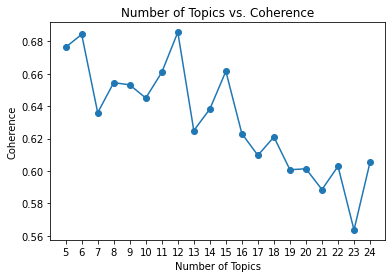

In [16]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()


In [18]:
coherence_neg = pickle.load(open('../data/topic_modeling/lda_model/coherence_neg.pkl','rb'))

In [19]:
x_val_neg = [x[0] for x in coherence_neg]
y_val_neg = [x[1] for x in coherence_neg]

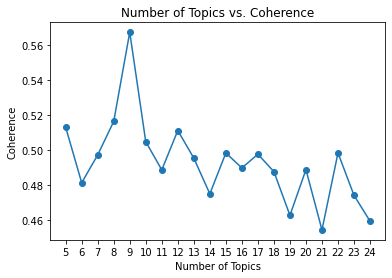

In [20]:
plt.plot(x_val_neg,y_val_neg)
plt.scatter(x_val_neg,y_val_neg)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val_neg)
plt.show()


In [21]:
Lda = models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_pos, num_topics=6, id2word = dictionary_pos, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
ldamodel.save('../data/topic_modeling/lda_model/positive_300000_6/lda_model_positive_6.model')
pickle.dump(ldamodel, open('../data/topic_modeling/lda_model/positive_300000_6/lda_model_positive_6.pkl', 'wb'))

In [22]:
Lda = models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_pos, num_topics=12, id2word = dictionary_pos, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
ldamodel.save('../data/topic_modeling/lda_model/positive_300000_12/lda_model_positive_12.model')
pickle.dump(ldamodel, open('../data/topic_modeling/lda_model/positive_300000_12/lda_model_positive_12.pkl', 'wb'))

In [29]:
Lda = models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_neg, num_topics=5, id2word = dictionary_neg, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
ldamodel.save('../data/topic_modeling/lda_model/negative_300000_5/lda_model_negative_5.model')
pickle.dump(ldamodel, open('../data/topic_modeling/lda_model/negative_300000_5/lda_model_negative_5.pkl', 'wb'))

In [30]:
Lda = models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_neg, num_topics=9, id2word = dictionary_neg, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
ldamodel.save('../data/topic_modeling/lda_model/negative_300000_9/lda_model_negative_9.model')
pickle.dump(ldamodel, open('../data/topic_modeling/lda_model/negative_300000_9/lda_model_negative_9.pkl', 'wb'))

In [24]:
lda_pos_6 = models.LdaModel.load('../data/topic_modeling/lda_model/positive_300000_6/lda_model_positive_6.model')

In [26]:
topic_data_pos_6 =  pyLDAvis.gensim.prepare(lda_pos_6, doc_term_matrix_pos, dictionary_pos, mds = 'pcoa')
pyLDAvis.display(topic_data_pos_6)

/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [27]:
lda_pos_12 = models.LdaModel.load('../data/topic_modeling/lda_model/positive_300000_12/lda_model_positive_12.model')

In [28]:
topic_data_pos_12 =  pyLDAvis.gensim.prepare(lda_pos_12, doc_term_matrix_pos, dictionary_pos, mds = 'pcoa')
pyLDAvis.display(topic_data_pos_12)

/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [31]:
lda_neg_5 = models.LdaModel.load('../data/topic_modeling/lda_model/negative_300000_5/lda_model_negative_5.model')

In [32]:
topic_data_neg_5 =  pyLDAvis.gensim.prepare(lda_neg_5, doc_term_matrix_neg, dictionary_neg, mds = 'pcoa')
pyLDAvis.display(topic_data_neg_5)

/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [33]:
lda_neg_9 = models.LdaModel.load('../data/topic_modeling/lda_model/negative_300000_9/lda_model_negative_9.model')

In [34]:
topic_data_neg_9 =  pyLDAvis.gensim.prepare(lda_neg_9, doc_term_matrix_neg, dictionary_neg, mds = 'pcoa')
pyLDAvis.display(topic_data_neg_9)

/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [ ]:
lda_neg = models.LdaModel.load('../data/topic_modeling/lda_model/negative_300000/lda_model_negative.model')

In [13]:
#dictionary_neg = pickle.load(open('../data/topic_modeling/pretrained/neg_dictionary.pkl','rb'))
#doc_term_matrix_neg = pickle.load(open('../data/topic_modeling/pretrained/neg_doc_term_matrix.pkl','rb'))
topic_data_neg =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix_neg, dictionary_neg, mds = 'pcoa')
pyLDAvis.display(topic_data_neg)

/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/feegee2000/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [ ]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
lemma = []
for text in tq.tqdm(pos_df.body):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    lemma.append(lemmatized_output)
pos_df.body = lemma

lemma = []
for text in tq.tqdm(neg_df.body):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    lemma.append(lemmatized_output)
neg_df.body = lemma

In [ ]:
player_nicknames = ['leo','cr7','chicharito','hulk','dave','rhino','rino']

In [ ]:
player_names = pickle.load(open('../data/pretrained/premier_player_names.pkl','rb'))

In [ ]:
team_names = ['arsenal','gunners','milan','ac','acmilan','rossoneri','atlético','atletico','madrid','barcelona','barca',
             'borussia','dortmund','borussiadortmund','schwarzgelben','chelsea','munich','bayern','münchen','inter',
             'intermilan','nerazzurri','juve','juventus','liverpool','reds','manchester','mancity','city','mcfc','psg','paris',
             'saint-germain','saint','germain','real','united','manutd','utd','man','mufc','devels','red','blue','roma',
             'tottenham','spurs','spur','hotspur','hotspurs','aston', 'villa','brentford','beighton','burnley','cystal', 'fulham', 'bromwich','albion','sheffield',
             'palace','everton','leeds','leicester','newcastle','norwich','southampton','swansea','watford','ham','wolverhampton','wanderers',
             'alavés','athletic','celta','vigo','elche','espanyol','getafe','granada','levante','mallorca','osasuna','vallecano',
             'betis','sociedad','sevilla','valencia','villarreal','atlanta','bologna','cagliari','empoli','fiorentina','genoa',
             'verona','internazionale','lazio','napoli','salernitana','sampdoria','sassuolo','spezia','torino','udinese','venezia',
             'arminia','bielefeld','leverkusen','bochum','mönchengladbach','eintracht','frankfurt','freiburg','hertha','hoffenhiem',
             'köln','leipzig','mainz','stuttgart','union','berlin','wolfsburg','lille','lyon','marseille','monaco','nantes','nice']

In [ ]:
time_words = ['mon','tue','wed','thu','fri','sat','sun','jan','feb','mar','apr','may','jun','jul','aug','sep',
              'oct','nov','dec','monday','tuesday','wednesday','thursday','friday','saturday','sunday','january',
              'feburary','march','april','may','june','july','august','september','october','november','december',
              '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023',
              '2024','2025','2026','2027','year','time','tomorrow','today','yesterday','day','week']

In [ ]:
def stopwords_generation():
    stop = stopwords.words('english')
    stop.extend([x.replace("\'", "") for x in stop])
    stop.extend(['nbsp', 'also', 'really', 'ive', 'even', 'jon', 'lot', 'could', 'many','x200b','would','one','remove','removed','delete','deleted',
             'juventusnews24','get','football'])
    stop.extend(player_names)
    stop.extend(time_words)
    stop.extend(player_nicknames)
    stop.extend(team_names)
    stop = list(set(stop))
    return stop

In [ ]:
def vector_generation(text,output_path):
    stop = stopwords_generation()
    cv = CountVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001,
                     stop_words=stop, ngram_range=(1,1),lowercase=False,dtype='uint8')

    tfidf = TfidfVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                        stop_words=stop, ngram_range=(1,1), lowercase=False,
                        sublinear_tf=True, smooth_idf=False, dtype='float32')
    cv_vecs = cv.fit_transform(text).transpose()
    tf_vecs = tfidf.fit_transform(text).transpose()
    print("Sparse Shape:", cv_vecs.shape) 
    print('CV:', sys.getsizeof(cv_vecs))
    print('Tf-Idf:', sys.getsizeof(tf_vecs))
    pickle.dump(cv_vecs, open(output_path+'cv_vecs.pkl', 'wb'))
    pickle.dump(tf_vecs, open(output_path+'tfidf_vecs.pkl', 'wb'))
    return cv,tfidf,cv_vecs,tf_vecs

In [ ]:
cv_pos,tfidf_pos,cv_vecs_pos, tf_vecs_pos = vector_generation(pos_df.body,'../data/topic_modeling/pretrained/pos_')
cv_neg,tfidf_neg,cv_vecs_neg, tf_vecs_neg = vector_generation(neg_df.body,'../data/topic_modeling/pretrained/neg_')

In [ ]:
def vector_info(cv_vecs,tf_vecs):
    
    tfidf_df = pd.DataFrame(tf_vecs.transpose().todense(), columns=[tfidf.get_feature_names()]).astype('float32')
    cv_df = pd.DataFrame(cv_vecs.transpose().todense(), columns=[cv.get_feature_names()]).astype('uint8')
    print(cv_df.info())
    print(tfidf_df.info())
    cv_description = cv_df.describe().T
    tfidf_description = tfidf_df.describe().T
    print(tfidf_df.sum().sort_values(ascending=False))

In [ ]:
def Trunc_SVD(vectorized, n_components=500, iterations=1, normalize=False, random_state=42):
    """
    Performs LSA/LSI on a sparse document term matrix, returns a fitted, transformed, (normalized) LSA object
    """
    # Already own the vectorized data for LSA, just transpose it back to normal
    vecs_lsa = vectorized.T

    # Initialize SVD object as LSA
    lsa = TruncatedSVD(n_components=n_components, n_iter=iterations, algorithm='randomized', random_state=random_state)
    dtm_lsa = lsa.fit(vecs_lsa)
    print("Explained Variance - LSA {}:".format(n_components), dtm_lsa.explained_variance_ratio_.sum())
    if normalize:
        dtm_lsa_t = lsa.fit_transform(vecs_lsa)
        dtm_lsa_t = Normalizer(copy=False).fit_transform(dtm_lsa_t)
        return dtm_lsa, dtm_lsa_t
    return dtm_lsa


def plot_SVD(lsa, title, level=None):
    """
    Plots the singular values of an LSA object
    """
    plt.figure(num=1, figsize=(15,10))
    plt.suptitle(title, fontsize=22, x=.55, y=.45, horizontalalignment='left')
    plt.subplot(221)
    plt.title('Explained Variance by each Singular Value')
    plt.plot(lsa.explained_variance_[:level])
    
    plt.subplot(222)
    plt.title('Explained Variance Ratio by each Singular Value')
    plt.plot(lsa.explained_variance_ratio_[:level])
    
    plt.subplot(223)
    plt.title("Singular Values ('Components')")
    plt.plot(lsa.singular_values_[:level])
    plt.show()

In [ ]:
cv_dtm_lsa = Trunc_SVD(cv_vecs_pos,iterations=5)
plot_SVD(cv_dtm_lsa, title='Count Vectorizer', level=25)

tf_dtm_lsa = Trunc_SVD(tf_vecs_pos, iterations=5)
plot_SVD(tf_dtm_lsa, title='Term Frequency - \nInverse Document Frequency', level=25)

In [ ]:
print('SVD Value| CV | TFIDF')
print('Top 2:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:2])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:2])),3))
print('Top 3:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:3])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:3])),3))
print('Top 4:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:4])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:4])),3))
print('Top 5:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:5])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:5])),3))
print('Top 6:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:6])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:6])),3))
print('Top 7:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:7])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:7])),3))
print('Top 8:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:8])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:8])),3))
print('Top 16:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:16])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:16])),3))
print('Top 32:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:32])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:32])),3))
print('Top 64:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:64])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:64])),3))
print('Top 128:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:128])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:128])),3))
print('Top 256:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:256])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:256])),3))
print('Top 500:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:500])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:500])),3))

In [ ]:
# Close look at the elbow plots
def elbow(dtm_lsa):
    evr = dtm_lsa.explained_variance_ratio_[:20]
    print("Explained Variance Ratio (EVR):\n", evr)
    print("Difference in EVR (start 3):\n", np.diff(evr[2:]))
    plt.figure()
    plt.plot(-np.diff(evr[2:]))
    plt.xticks(range(-1,22), range(2,25))
    plt.suptitle('Difference in Explained Variance Ratio', fontsize=15);
    plt.title('Start from 3, moves up to 20');

# Count Vectorizer
elbow(cv_dtm_lsa)


In [ ]:
elbow(tf_dtm_lsa)

# LSA

In [ ]:
cv_corpus_pos = matutils.Sparse2Corpus(cv_vecs_pos)
pickle.dump(cv_corpus_pos, open('../data/topic_modeling/pretrained/pos_cv_corpus.pkl','wb'))
cv_corpus_neg = matutils.Sparse2Corpus(cv_vecs_neg)
pickle.dump(cv_corpus_neg, open('../data/topic_modeling/pretrained/neg_cv_corpus.pkl','wb'))

In [ ]:
id2word_pos = dict((v,k) for k, v in cv_pos.vocabulary_.items())
id2word_pos = corpora.Dictionary.from_corpus(cv_corpus_pos, id2word = id2word_pos)
pickle.dump(id2word_pos, open('../data/topic_modeling/pretrained/pos_id2word.pkl','wb'))

id2word_neg = dict((v,k) for k, v in cv_neg.vocabulary_.items())
id2word_neg = corpora.Dictionary.from_corpus(cv_corpus_neg, id2word = id2word_pos)
pickle.dump(id2word_neg, open('../data/topic_modeling/pretrained/neg_id2word.pkl','wb'))

In [ ]:
tfidf_corpus_pos = matutils.Sparse2Corpus(tf_vecs_pos)
pickle.dump(tfidf_corpus_pos, open('../data/topic_modeling/pretrained/pos_tf_corpus.pkl','wb'))
tfidf_corpus_neg = matutils.Sparse2Corpus(tf_vecs_neg)
pickle.dump(tfidf_corpus_neg, open('../data/topic_modeling/pretrained/neg_tf_corpus.pkl','wb'))

In [ ]:
tf_id2word_pos = dict((v,k) for k, v in tfidf_pos.vocabulary_.items())
tf_id2word_pos = corpora.Dictionary.from_corpus(tfidf_corpus_pos, id2word = tf_id2word_pos)
pickle.dump(tf_id2word_pos, open('../data/topic_modeling/pretrained/tf_id2word_pos.pkl','wb'))

tf_id2word_neg = dict((v,k) for k, v in tfidf_neg.vocabulary_.items())
tf_id2word_neg = corpora.Dictionary.from_corpus(tfidf_corpus_neg, id2word = tf_id2word_neg)
pickle.dump(tf_id2word_neg, open('../data/topic_modeling/pretrained/tf_id2word_neg.pkl','wb'))

In [ ]:
lsi = models.LsiModel(corpus = cv_corpus, id2word = id2word, num_topics=10)

In [ ]:
lsi_corpus = lsi[cv_corpus]
doc_vecs = [doc for doc in lsi_corpus]

In [ ]:
for i in range(10):
    print(lsi.print_topic(i, topn=10))

# Similarity Scoring

In [ ]:
index = similarities.MatrixSimilarity(doc_vecs)
docu = 0
sims = sorted(enumerate(index[doc_vecs[docu]]),key=lambda item:-item[1])
np.r_[sims[:10],sims[-10:]]

In [ ]:
for sim_doc_id, sim_score in sims[:11]: 
    print("\nScore:", sim_score)
    print("Document Text:\n", df.text[sim_doc_id])

# lda

In [ ]:
lda = models.LdaMulticore(corpus=tq.tqdm(cv_corpus), num_topics=15, id2word=id2word, passes=85, 
                              workers=13, random_state=42, eval_every=None, chunksize=6000)

In [ ]:
pickle.dump(lda, open('../data/pretrained/lda_gensim_v4.pkl', 'wb'))
lda.save('../data/pretrained/gensim_lda_v4.model')

In [ ]:
lda = models.LdaModel.load('../data/topic_modeling/lda_model/gensim_lda_positive.model')

In [ ]:
lda.print_topics(num_words=10, num_topics=10)

In [ ]:
lda.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

In [ ]:
topic_data =  pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)